In [1]:
import kagglehub
import os

path = kagglehub.dataset_download('rohitgrewal/airlines-flights-data')
print('Path Dataset berada di :', path)
print('Isi Folder :', os.listdir(path))

100%|██████████| 2.33M/2.33M [00:00<00:00, 46.6MB/s]

Extracting files...


Path Dataset berada di : /root/.cache/kagglehub/datasets/rohitgrewal/airlines-flights-data/versions/1
Isi Folder : ['airlines_flights_data.csv']


In [2]:
import pandas as pd

df = pd.read_csv( path + '/airlines_flights_data.csv')
df

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [3]:
df.drop(columns='index', inplace=True)
df.head(5)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [4]:
df.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

**PREPROCESSING**

In [5]:
Features = ['source_city','departure_time','stops','arrival_time','destination_city','class','days_left']

In [6]:
Fitur = df[Features]
Target = df['price']

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    Fitur, Target, random_state=42, test_size=0.2
)

In [8]:
print(f'Data Training berjumlah : {len(X_train)} dan Data Uji berjumlah : {len(X_test)}')

Data Training berjumlah : 240122 dan Data Uji berjumlah : 60031


In [9]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

scaler = StandardScaler()
num_features = ['days_left']
num_transform = scaler

In [10]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_features = ['source_city','departure_time','stops','arrival_time','destination_city']
cat_transform = encoder

In [11]:
ordinal_features = ['class']
class_categories = ['Economy','Business']
ordinal_transofrm = OrdinalEncoder(categories=[class_categories])

In [12]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

log_transform = FunctionTransformer(np.log1p, inverse_func=np.expm1)

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('log', log_transform),
        ('scaler', num_transform)]),num_features),
    ('ord', ordinal_transofrm, ordinal_features),
    ('cat', cat_transform, cat_features)
], remainder ='drop')

In [14]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(max_iter=10000)

In [15]:
from sklearn.compose import TransformedTargetRegressor

model_elastic = TransformedTargetRegressor(
    regressor = elastic,
    func = np.log1p,             # Transformasi target agar lebih stabil
    inverse_func= np.expm1
)

In [16]:
pipeline_elastic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model_elastic)
])

**HYPERPARAMETER TUNING**

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid_elastic = {
    'regressor__regressor__alpha' : [0.001, 0.01, 0.1, 1, 10, 100],
    'regressor__regressor__l1_ratio' : [0.2, 0.5, 0.8]
}

In [18]:
grid_elastic = GridSearchCV(
    pipeline_elastic,
    param_grid=param_grid_elastic,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose =2
)

In [19]:
grid_elastic.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['days_left']),
                                                                        ('ord',
                                                                         OrdinalEncoder(categories=[['Economy',
                                                                                                     'Business']]),
                                                                         ['class']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore...
                                                                         ['source_city',
                                                                          'departure_time',
                                                                          'stops',
                                                                          'arrival_time',
                                                                          'destination_city'])])),
                                       ('regressor',
                                        TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=<ufunc 'expm1'>,
                                                                   regressor=ElasticNet(max_iter=10000)))]),
             n_jobs=-1,
             param_grid={'regressor__regressor__alpha': [0.001, 0.01, 0.1, 1,
                                                         10, 100],
                         'regressor__regressor__l1_ratio': [0.2, 0.5, 0.8]},
             scoring='r2', verbose=2)

In [20]:
best_elastic = grid_elastic.best_estimator_

**EVALUATE MODEL**

In [21]:
print('Best Params yang ditemukan adalah :', grid_elastic.best_params_)
print('Best CV Scoring yang ditemukan adalah :', grid_elastic.best_score_)

Best Params yang ditemukan adalah : {'regressor__regressor__alpha': 0.01, 'regressor__regressor__l1_ratio': 0.5}
Best CV Scoring yang ditemukan adalah : 0.8563229605903431


In [22]:
print(best_elastic)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['days_left']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Business']]),
                                                  ['class']),
                                                 ('cat',
                   

In [23]:
y_pred = best_elastic.predict(X_test)

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('=== HASIL EVALUASI MODEL ELASTIC ===')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Hasil rmse model Elastic adalah : {rmse:.4f}')
print(f'Hasil MAE model Elastic adalah : {mae:.4f}')
print(f'Hasil r2 model Elastic adalah : {r2:.4f}')
print(f'Harga Aktual Pada Data Uji : \n {y_test.values}')
print(f'Harga Prediksi Model : \n {np.round(y_pred)}')

=== HASIL EVALUASI MODEL ELASTIC ===
Hasil rmse model Elastic adalah : 8587.9832
Hasil MAE model Elastic adalah : 4932.4175
Hasil r2 model Elastic adalah : 0.8569
Harga Aktual Pada Data Uji : 
 [ 7366 64831  6195 ...  6734  5082 66465]
Harga Prediksi Model : 
 [ 5343. 45859.  5742. ...  5578.  3366. 83411.]


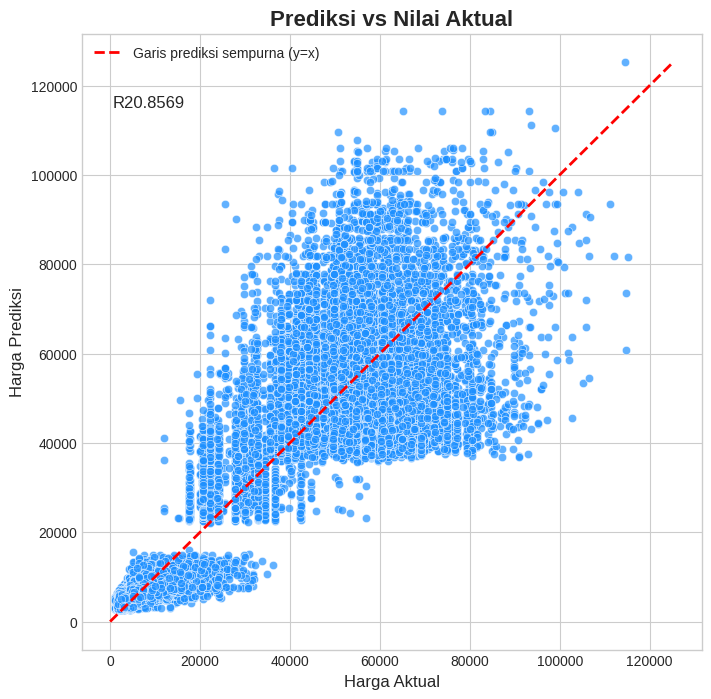

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

seaborn_version = 'seaborn-v0_8-whitegrid'

plt.figure(figsize=(8,8))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_test, y=y_pred, color='dodgerblue', alpha=0.7)
max_val = max(y_test.max(), y_pred.max())
y_pred.max()

plt.plot([0, max_val],[0, max_val], 'r--', lw=2, label='Garis prediksi sempurna (y=x)')
plt.title('Prediksi vs Nilai Aktual', fontsize=16, fontweight='bold')
plt.xlabel('Harga Aktual',fontsize=12)
plt.ylabel('Harga Prediksi', fontsize=12)
plt.legend()
plt.text(0.05, 0.9, f'R2{r2:.4f}', transform=plt.gca(). transAxes, fontsize=12, verticalalignment='top')
plt.show()

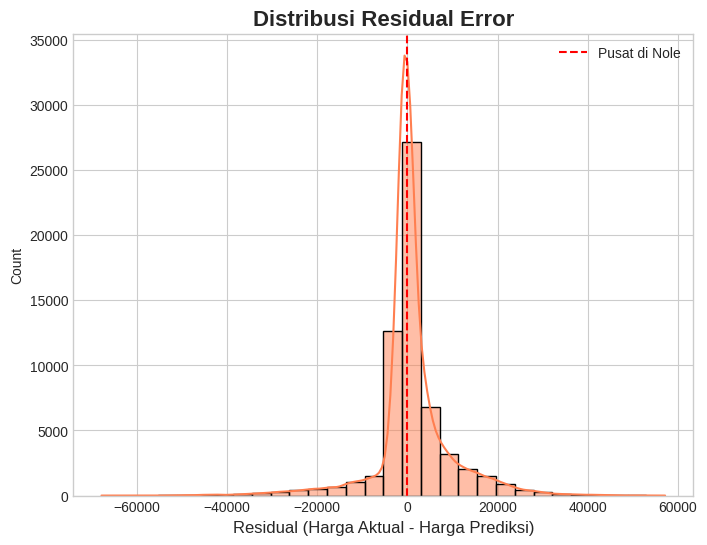

In [27]:
residual = y_test - y_pred

plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.histplot(residual, kde=True, color='coral', bins=30)
plt.title('Distribusi Residual Error', fontsize=16, fontweight='bold')
plt.xlabel('Residual (Harga Aktual - Harga Prediksi)', fontsize=12)
plt.axvline(0, color='r', linestyle='--', label='Pusat di Nole')
plt.legend()
plt.show()

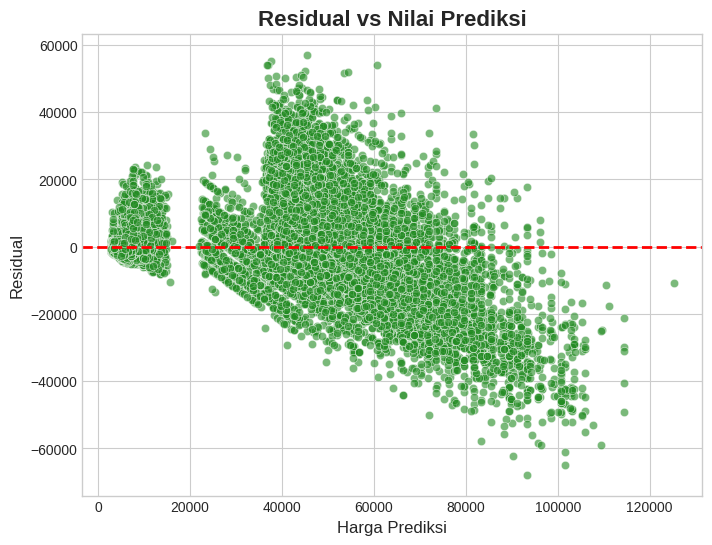

In [28]:
plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_pred, y=residual, color='forestgreen', alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.title('Residual vs Nilai Prediksi', fontsize=16, fontweight='bold')
plt.xlabel('Harga Prediksi', fontsize=12)
plt.ylabel('Residual', fontsize=12)
plt.show()

In [33]:
# Mengambil langkah preprocessornya dan regressornya

preprocessor = best_elastic.named_steps['preprocessor']
model = best_elastic.named_steps['regressor'].regressor_

In [34]:
feature_name = []

# Numeric StandardScaler preprocessor
num_fitur = preprocessor.transformers_[0][2]
feature_name.extend(num_fitur)

# Ordinal preprocessor
ordinal_fitur = preprocessor.transformers_[1][2]
feature_name.extend(ordinal_fitur)

# OneHotEncoder preprocessor
cat_fitur = preprocessor.transformers_[2][1]
cat_feat = cat_fitur.get_feature_names_out(preprocessor.transformers_[2][2])
feature_name.extend(cat_feat)

In [35]:
# Buat DataFrame

koefisien = model.coef_
feature_importances = pd.DataFrame({
    'Feature': feature_name,
    'Coeficient': koefisien
})

In [38]:
feature_importances['Abs_Coefficient'] = feature_importances['Coeficient'].abs()
feature_importances = feature_importances.sort_values('Abs_Coefficient', ascending=False)
feature_importances.head(10)

,Feature,Coeficient,Abs_Coefficient
1,class,2.084978,2.084978
16,stops_zero,-0.496664,0.496664
0,days_left,-0.214939,0.214939
6,source_city_Kolkata,0.119384,0.119384
15,stops_two_or_more,0.091542,0.091542
27,destination_city_Kolkata,0.075976,0.075976
19,arrival_time_Evening,0.043510,0.043510
20,arrival_time_Late_Night,-0.039174,0.039174
12,departure_time_Morning,0.023441,0.023441
22,arrival_time_Night,0.019909,0.019909


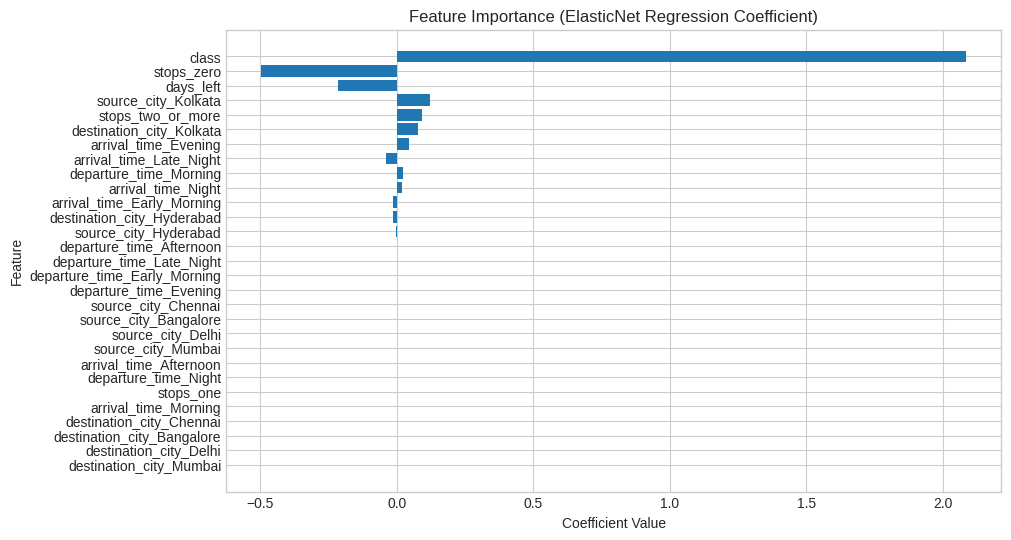

In [41]:
plt.figure(figsize=(10,6))
plt.barh(feature_importances['Feature'], feature_importances['Coeficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (ElasticNet Regression Coefficient)')
plt.gca().invert_yaxis()
plt.show()

In [42]:
from google.colab import files
import joblib

joblib.dump(best_elastic, 'ElasticNet_pipeline_predictions_price.pkl')

['ElasticNet_pipeline_predictions_price.pkl']

In [43]:
files.download('ElasticNet_pipeline_predictions_price.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>